In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/WirelessMLCodes/CEL_SS/2023SPRVersion')

In [2]:
'''2024 Feb version. model pre-trained on normal 2xdata, tested with PUs using Random Mod type 
CEL vs Energy detection, 2022 Mar 14 Trying on Colab. 
It seems that processing small batch is slow, 7s per epoch per user
Big batch can accelerate to less than 2s per epoch per user
Copied on 2023Feb3'''
import torch
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import math
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.distributed as TUDdistributed
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import sys
from copy import deepcopy
import random
import collections
#from MobileNetV1_CriticalPath import Net
import matplotlib.pyplot as plt
import pandas as pd 
# from sklearn.externals import joblib
from cnn_models import standalone_cnn
from cnn_models import decouple_cnn
from cnn_models import decouple_cnn_mod

from pytz import timezone
TMZ = timezone('EST')
import datetime
import shutil
import time

device = torch.device("cuda")
# if os.environ["CUDA_VISIBLE_DEVICES"]:
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

# device = torch.device("cpu")
use_cuda = True
criterion = nn.CrossEntropyLoss()

random.seed(0) 

      

def create_net(list, per_class_filter, ty_chs):
    number_class = len(list) # list of locally observable channels
    d_w = number_class*per_class_filter
    cfg = [40, d_w, d_w, d_w ]
    print('corresponding cfg channel list:',cfg)
    net = decouple_cnn_mod( nch=number_class, cfg=cfg, ty_chs=ty_chs)
    net.to(device)
    return net

def testnetsVote(model_list, class_dir, test_loader, coef_list, gain_dif, thresh_sig = 0.5):                             
    '''default for FL CEL stdaln, Tests all nodes together, apply majority vote for each band 
    '''
    total = 0 #sum of occupation and emptiness
    test_loss = 0 
    total_ocp = 0 #occupied bands
    total_emp = 0 #empty bands
    correct = 0
    total_cmb = 0  #occupation combination
    correct_ocp = 0
    correct_emp = 0
    correct_cmb = 0
    thresh_logit = -1*(math.log(thresh_sig**(-1) -1))
    # thresh_logit = thresh_sig
    
    with torch.no_grad():
        criterion = nn.BCEWithLogitsLoss()
        for batchidx, (data, target) in enumerate(test_loader):
            target =  target.cuda()
            #print(target.size())
            target = Variable(target)
            target = Variable(target)
#             print('target size is:',target.size())
            output_manual = torch.zeros(target.shape) # manual global decision, float version
            total_batch = float(torch.tensor(target.size()).prod()) #total num of channels in this batch
            total += total_batch
            total_cmb += float(target.size(0))
            total_ocp += float(target.sum())
            total_emp += float(total_batch - target.sum()) 
            if (1-target).sum() != (torch.tensor(target.size()).prod() - target.sum()) : #Testing tensor dim =========
                print('show difference:',(1-target).sum(), total - target.sum())
                print('total ocp/emp calculation wrong')
            '''Above calculate the total number of channels detected and the ground truth number of occupation/emptiness'''
            coef = torch.tensor(coef_list)
            for idx in range(len(class_dir)): # appply fusion strategy on local_node detections
                model_list[idx].eval()
                datain = Variable(gain_dif*1e7*data[idx]).cuda() #1e7 to boost gradient
                localout = (model_list[idx](datain).cpu()>thresh_logit).float()
                output_manual[:,class_dir[idx]] = output_manual[:,class_dir[idx]].add_(localout) #add local detection result
                # output_manual[:,class_dir[idx]] = output_manual[:,class_dir[idx]]|(model_list[idx](datain).cpu()>thresh_logit)
            out_WOnorm = output_manual
            output_manual = output_manual.div_( coef ) > 0.49 #get fusion decision
            if batchidx == -1 :
                id = 90
                print('label:',target[id])
                print('un-normalized fusion:', torch.norm(out_WOnorm))
                print('SU fusion:',output_manual[id])

            correct_ocp += (output_manual*target.cpu()).sum()
            correct_emp += ((~output_manual)*(1-target.cpu())).sum()
            correct_cmb += (~(output_manual^( target.bool().cpu() ))).float().prod(1).sum() #use XNOR which is 'not+XOR'

            loss = criterion(output_manual.float().cuda(), target)
            test_loss += loss.item()
            # print(output, loss.item())

        correct_tol = deepcopy(correct_ocp) + deepcopy(correct_emp) #just sum
        accuracy_tol = 100*correct_tol/total
        accuracy_pd = 100*correct_ocp/total_ocp
        accuracy_pfa = 100*correct_emp/total_emp
        accuracy_cmb = 100*correct_cmb/total_cmb

    loss = loss.item()
    print('test last batch',(~(output_manual^target.bool().cpu())).float().prod(1).sum() / target.size(0))
    print('++++++++++++++++++ Accuracy on global set: total: %d %%, combination: %d %%, PD: %d %%, PFA: %d %%, loss: %.3f' \
                                            % ( accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa, loss))
    return (accuracy_tol, accuracy_pd, 100-accuracy_pfa)


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    des = 0.1 #0.1
    epoch_inter = 20
    bs = 0.2
    # bs = 1
    lr = 0.05 * bs ** (epoch//epoch_inter)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(model, epoch, class_list, train_loader, thresh_sig = 0.5):
    '''Use NodeDatasetMaker by default, trainloader only gives local data and only trains a local model'''
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4) #decay=0 
    # optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4) #
    # optimizer = optim.AdamW(model.parameters(), lr=0.1, weight_decay=1e-4) #
    adjust_learning_rate(optimizer, epoch)
    sys.stdout.flush()

    for param_group in optimizer.param_groups:
        print('Learning Rate: %f' % param_group['lr'])
    model.train()
    thresh_logit = -1*(math.log(thresh_sig**(-1) -1))
    train_loss = 0
    criterion = nn.BCEWithLogitsLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)     
        #print( data.size() )
        data, target = Variable(data*1e7), Variable(target)
        optimizer.zero_grad()
        #output = model(data, len(class_list))
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()#remains to be edited
    return model

def gather_layer_MDLT(model): # Gather layers of a model to 3 categories: convlist, batchnormlist, fclist
    convlist = []
    batchnormlist= []
    
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            convlist.append(layer)
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.GroupNorm):
            batchnormlist.append(layer)
    fclist =model.fc # should be nn.modulelist
    return convlist, batchnormlist, fclist


def Merge_MDLT(net_list, net_t, idx_list, coef_list, shared_layers, class_dir): #for adjustable layers in "256 256 256"
#--------------------------------------create and zero dic_tol-----------------------------------
    net_tol = deepcopy(net_t)
    dict_tol = net_tol.state_dict()

    for name in list( dict_tol ):  #zero dict_tol
        dict_tol[name].data.zero_()

    net_tol.load_state_dict(dict_tol) #make zero net_tol
    convlist_n0, batchnormlist_n0, fclist_n0  = gather_layer_MDLT(net_tol)
#----------------------------------------Add node params to net_tol------------------------------------------
    for i in range( len(net_list) ):
        convlist_ni, batchnormlist_ni, fclist_ni  = gather_layer_MDLT(net_list[i])
        #---------------------------------------Merge shared layers------------------------
        for [m0, mi] in zip( convlist_n0[0:shared_layers], convlist_ni[0:shared_layers] ):
            m0.weight.data += mi.weight.data /len(class_dir)
            m0.bias.data += mi.bias.data /len(class_dir) 

        for [m0, mi] in zip( batchnormlist_n0[0:shared_layers], batchnormlist_ni[0:shared_layers] ):
            m0.weight.data += mi.weight.data /len(class_dir) # batchnormlist has weight?
            m0.bias.data += mi.bias.data /len(class_dir)
            if isinstance(m0, nn.BatchNorm2d):
                m0.running_mean.data += mi.running_mean.data /len(class_dir)
                m0.running_var.data += mi.running_var.data /len(class_dir)
        #-----------------------------------------Merge (add) Critical Paths 256 Convs----------------------------
        for [m0, mi] in zip( convlist_n0[shared_layers:], convlist_ni[shared_layers:] ):
            for j in range( len(idx_list[i]) ):
                idx = idx_list[i][j]
                Lx1 = mi.weight.data.size(0) // len(idx_list[i])
                #print(m0.weight.data.size(), mi.weight.data.size())
                m0.weight.data[ idx*Lx1 : (idx+1)*Lx1 ] += mi.weight.data[ j*Lx1: (j+1)*Lx1 ] /coef_list[ idx ]
                m0.bias.data[ idx*Lx1 : (idx+1)*Lx1 ] += mi.bias.data[ j*Lx1: (j+1)*Lx1 ] /coef_list[ idx ]     
        #-----------------------------------------Merge (Add) critical paths 256 BN --------------------------------------
        for [m0, mi] in zip( batchnormlist_n0[shared_layers:], batchnormlist_ni[shared_layers:] ):
            for j in range( len(idx_list[i]) ):
                idx = idx_list[i][j]
                Lx1 = mi.weight.data.size(0) // len(idx_list[i])
                m0.weight.data[ idx*Lx1 : (idx+1)*Lx1 ] += mi.weight.data[ j*Lx1: (j+1)*Lx1 ] /coef_list[ idx ]
                m0.bias.data[ idx*Lx1 : (idx+1)*Lx1 ] += mi.bias.data[ j*Lx1: (j+1)*Lx1 ] /coef_list[ idx ]

                if isinstance(m0, nn.BatchNorm2d):
                    m0.running_mean.data[ idx*Lx1 : (idx+1)*Lx1 ] += mi.running_mean.data[ j*Lx1: (j+1)*Lx1 ] /coef_list[ idx ]
                    m0.running_var.data[ idx*Lx1 : (idx+1)*Lx1 ] += mi.running_var.data[ j*Lx1: (j+1)*Lx1 ] /coef_list[ idx ]
        #-----------------------------------------Merge (Add) FC-------------------------------------------------
        for j in range( len(idx_list[i]) ):  # here fclist_xx is nn.modulelist 
            idx = idx_list[i][j]
            fclist_n0[idx].weight.data += fclist_ni[j].weight.data/ coef_list[idx]
            fclist_n0[idx].bias.data += fclist_ni[j].bias.data/ coef_list[idx]

    return net_tol    


def Split_MDLT(net_list, net_tol, idx_list, coef_list, shared_layers, class_dir):

    convlist_n0, batchnormlist_n0, fclist_n0  = gather_layer_MDLT(net_tol)
    # shared_layers= 1
    list_shared = list( range(shared_layers) )
    for i in range(len(net_list)):
        convlist_ni, batchnormlist_ni, fclist_ni  = gather_layer_MDLT(net_list[i])
        #---------------------------Split Shared Layers-----------------------------------------
        for a in list_shared: # Split layers marked in list_shared
            #kk = 0
            for [m0, mi] in zip( convlist_n0[a:a+1], convlist_ni[a:a+1] ):       
                #kk += 1
                mi.weight.data = deepcopy(m0.weight.data) # for convs in common, just update             
                mi.bias.data = deepcopy(m0.bias.data) # for convs in common, just update       
            for [m0, mi] in zip( batchnormlist_n0[a:a+1], batchnormlist_ni[a:a+1] ):
                mi.weight.data = deepcopy(m0.weight.data)
                mi.bias.data = deepcopy(m0.bias.data)
                if isinstance(m0, nn.BatchNorm2d):
                    mi.running_mean.data = deepcopy(m0.running_mean.data)
                    mi.running_var.data = deepcopy(m0.running_var.data)
        #--------------------------Split Critical paths, convs ----------------------------------
        for [m0, mi] in zip( convlist_n0[shared_layers:], convlist_ni[shared_layers:] ):
            for j in range( len( idx_list[i] ) ): # dealwith every critical pth on node
                idx = idx_list[i][j]
                Lx1 = mi.weight.data.size(0) // len(idx_list[i])
                mi.weight.data[ j*Lx1 : (j+1)*Lx1 ] = deepcopy(m0.weight.data[ idx*Lx1 : (idx+1)*Lx1 ])
                mi.bias.data[ j*Lx1 : (j+1)*Lx1 ] = deepcopy(m0.bias.data[ idx*Lx1 : (idx+1)*Lx1 ])
        #--------------------------Split Critical paths, BN -------------------------------------
        for [m0, mi] in zip( batchnormlist_n0[shared_layers:], batchnormlist_ni[shared_layers:] ):
            for j in range( len( idx_list[i] ) ):
                idx = idx_list[i][j]
                Lx1 = mi.weight.data.size(0) // len(idx_list[i])
                mi.weight.data[ j*Lx1 : (j+1)*Lx1 ] = deepcopy(m0.weight.data[ idx*Lx1 : (idx+1)*Lx1 ])
                mi.bias.data[ j*Lx1 : (j+1)*Lx1 ] = deepcopy(m0.bias.data[ idx*Lx1 : (idx+1)*Lx1 ])

                if isinstance(m0, nn.BatchNorm2d):
                    mi.running_mean.data[ j*Lx1 : (j+1)*Lx1 ] = deepcopy(m0.running_mean.data[ idx*Lx1 : (idx+1)*Lx1 ])
                    mi.running_var.data[ j*Lx1 : (j+1)*Lx1 ] = deepcopy(m0.running_var.data[ idx*Lx1 : (idx+1)*Lx1 ])       
        #-------------------------Split FC layerrrr ---------------------------------------------
        for j in range( len(idx_list[i]) ): # fclist_nX is nn.modulelist
            idx = idx_list[i][j]
            fclist_ni[j].weight.data = deepcopy(fclist_n0[idx].weight.data)
            fclist_ni[j].bias.data = deepcopy(fclist_n0[idx].bias.data)

    return net_list

def Dis_analysis(class_dir, tol_list):
  #idx_list: list of lists, global positions of locally observable bands for each node
  #coef_list: coef for averaging the param for each band, how many nodes are learning each certain band
    idx_list = []
    coef_list = [0]*len( tol_list )
    for i in range( len(class_dir) ): #Generating the mapping btw nodes and net_tol
        sub_idx_list = [] 
        for j in class_dir[i]:
            for k in range( len(tol_list) ):
                if j == tol_list[k]:
                    sub_idx_list.append(k)
                    coef_list[k] += 1 
                    break
        idx_list.append(sub_idx_list)
    return idx_list, coef_list


"""626/720 dataset maker, each logit corresponds to the occupation of a single channel"""
class TotalDatasetMaker(Dataset):
    "simple version that requires the user to edit input/label format elsewhere"
    def __init__(self, db, label_list, transformFunc ):
        """
        db: a list of input signal tensors, label_list: a list of data labels, corresponding to db.
        """
        self.datasets = db
        self.label_list = label_list
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        img = self.datasets[i]
        img = self.transformFunc(img)
        class_label = self.label_list[i]
        return img, class_label

    def __len__(self):
        return len(self.label_list)
    
    
"""720 dataset maker, data looks like: each global channel occupation condition ==> 
each node only learn from 'local' received signal(full size for each node) which is an element in the list of this condition """
class NodeDatasetMaker(Dataset):

    def __init__(self, db, label_list, node, class_dir, transformFunc ):
        """
        db: a list of input signal tensors, label_list: a list of data labels, corresponding to db.
        node
        """
        self.datasets = db
        self.label_list = label_list
        self.transformFunc = transformFunc
        self.chn_list = class_dir[node]
        self.node = node
    def __getitem__(self, i):
        img = self.datasets[i][self.node]
        img = self.transformFunc(img)
        class_label = self.label_list[i][self.chn_list]
        return img, class_label

    def __len__(self):
        return len(self.label_list)

def setDir(filepath):
  # if directory not exist, create. if directory already exist, empty it.
  if not os.path.exists(filepath):
    os.makedirs(filepath)
  else:
    print('Directory already exists')
    shutil.rmtree(filepath, ignore_errors = True)
    os.mkdir(filepath)
       
print('start')

start


/tmp/ipykernel_3684286/2355447393.py:25: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
corresponding cfg channel list: [40, 160, 160, 160]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding cfg channel list: [40, 40, 40, 40]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding cfg channel list: [40, 56, 56, 56]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding cfg channel list: [40, 64, 64, 64]
corresponding cfg channel list: [40, 56, 56, 56]
correspondi

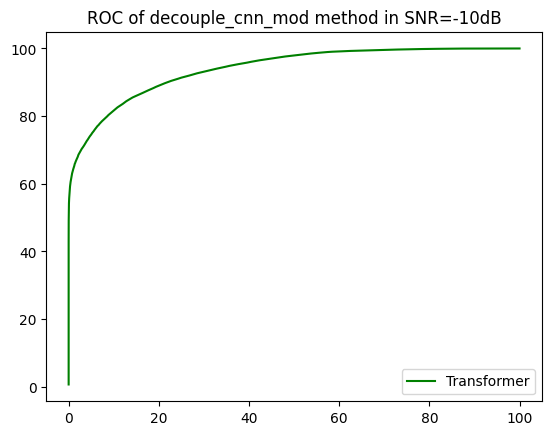

ROC in Excel saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-10dBVol20_240209_22_37/ROC_SNR-10.xlsx
ROC in Lists saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-10dBVol20_240209_22_37/decouple_cnn_modROC.pth
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
corresponding cfg channel list: [40, 160, 160, 160]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding cfg channel list: [40, 40, 40, 40]
corresponding cfg channel list: [4

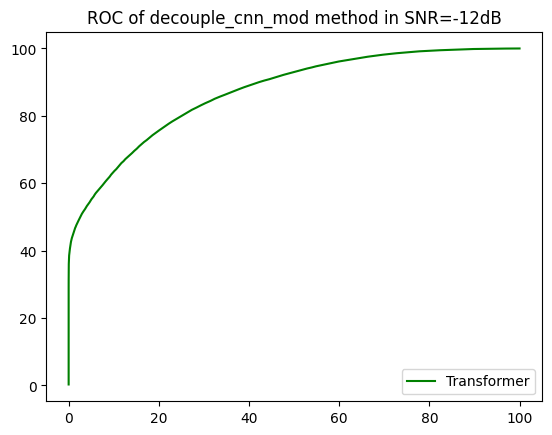

ROC in Excel saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-12dBVol20_240209_22_41/ROC_SNR-12.xlsx
ROC in Lists saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-12dBVol20_240209_22_41/decouple_cnn_modROC.pth
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
corresponding cfg channel list: [40, 160, 160, 160]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding cfg channel list: [40, 40, 40, 40]
corresponding cfg channel list: [4

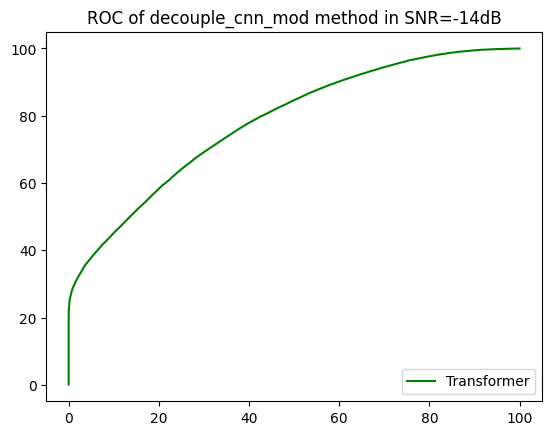

ROC in Excel saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-14dBVol20_240209_22_45/ROC_SNR-14.xlsx
ROC in Lists saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-14dBVol20_240209_22_45/decouple_cnn_modROC.pth
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
corresponding cfg channel list: [40, 160, 160, 160]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding cfg channel list: [40, 40, 40, 40]
corresponding cfg channel list: [4

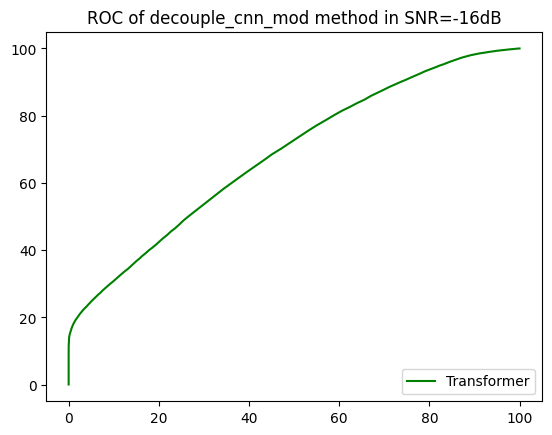

ROC in Excel saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-16dBVol20_240209_22_52/ROC_SNR-16.xlsx
ROC in Lists saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-16dBVol20_240209_22_52/decouple_cnn_modROC.pth
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
corresponding cfg channel list: [40, 160, 160, 160]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding cfg channel list: [40, 40, 40, 40]
corresponding cfg channel list: [4

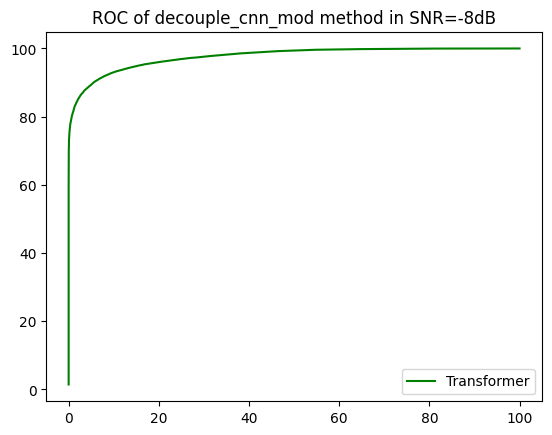

ROC in Excel saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-8dBVol20_240209_22_58/ROC_SNR-8.xlsx
ROC in Lists saved to: Saved_Models/SwitchPU/decouple_cnn_mod/SNRs/-8dBVol20_240209_22_58/decouple_cnn_modROC.pth


In [4]:
 # for snr in [12, 8 ]: #[12, 8, 14, 16, 20]: #[12, 8 ]: #[12, 8, 14, 16, 20]
for snr in [10,12,14,16,8]: #: #[12, 8 ]: #[12, 8, 14, 16, 20][12, 14, 16, 4, 2 ]
    roc_dots = 100
    volum = 20
    SNR= -1*snr 
    nepoch = 0
    DistAmp_tr = 10 # DistAmp = 10 #25
    DistAmp_te = 10
    alpha_tr = 3.71
    alpha_te = 3.71
    gain_dif= (DistAmp_te*2*3**0.5 /3)**alpha_te / (DistAmp_tr*2*3**0.5 /3)**alpha_tr #(DistAmp_te/DistAmp_tr)**3.71 # 3.71 is alpha in pathloss. gain_dif is used to normalize test data
    # gain_dif=1# 0.9 sweep gain_dif to check
    stage_dir='/SNRs/'#for naming and directory

    # datadir_tr = 'RefinedNewData/SNRs/'+str(DistAmp_tr)+'m/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    # datadir_te = 'RefinedNewData/SNRs/'+str(DistAmp_te)+'m/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    # datadir_te = 'RefinedNewData/SNRs/'+str(DistAmp_te)+'m_Alpha5/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    # datadir = 'RefinedNewData/SNRs/RandMod/Data_SNR'+str(SNR)+'vol1'+'.pth' # RandMod: revision dataset, PU mod varying (testing data only)
    datadir = 'RefinedNewData/SNRs/PUswitch/Data_SNR'+str(SNR)+'vol1.pth'
    datadir_te = datadir
    datadir_tr = datadir
    Model_dir = 'Saved_Models/decouple_cnn_mod/LoadedModel/'+str(SNR)+'dBVol20' # 2023 models
    # Model_dir = 'Saved_Models/decouple_cnn_mod/SNRs/RandMod_Retrain/'+str(SNR)+'dBVol20_OLD'#-4dB retrained CEL

    data_dict_tr = torch.load(datadir_tr)
    data_dict_te = torch.load(datadir_te)
    data_dict_tr.keys()

    db = data_dict_tr['training data list']
    label_list = data_dict_tr['training label list']

    db_te = data_dict_te['testing data list']
    label_list_te = data_dict_te['testing label list']

    # Create models ==================================================================================================
    per_class_filter = 8
    #fms = 16 #size of final conv feature map
    shared_layers = 1
    # class_dir=[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
    class_dir= [[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]]
    tol_list = []
    for classi in class_dir:
        tol_list += classi
    tol_list = list( set(tol_list) )
    tol_list.sort()

    print(class_dir)
    print(tol_list)

    # get coef 
    idx_list, coef_list = Dis_analysis(class_dir, tol_list)
    print(idx_list, coef_list)

    #Parepare nets
    net_list = []
    net_tol = create_net(tol_list, per_class_filter, True) 
    Acc_tol=[]
    Acc_list = []

    for i in range(len(class_dir)):
        net_list.append(create_net(class_dir[i], per_class_filter, True))
        Acc_list.append([])

    db_tr_list = []
    for idx in range(len(class_dir)):# train datasets are more complex
        db_tr_list.append(NodeDatasetMaker( db, label_list, idx, class_dir, transforms.Compose([ ]) ))
    db_te_1 = TotalDatasetMaker( db_te, label_list_te, transforms.Compose([ ]) )

    train_loader_list = []
    for idx in range(len(class_dir)):# trainloaders are more complex
        train_loader_list.append(DataLoader(db_tr_list[idx], batch_size=50, shuffle=True, num_workers=0, pin_memory=True))
    # tol_train_loader = DataLoader(tol_trainsets, batch_size=100, shuffle=False, num_workers=0, pin_memory=True)
    tol_test_loader = DataLoader(db_te_1, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

    now=datetime.datetime.now(TMZ) #time watermark
    time_watermark = now.strftime('%y%m%d_%H_%M')
    print('model watermark',time_watermark)
    address_model = 'Saved_Models/SwitchPU/'+type(net_list[0]).__name__+stage_dir+str(SNR)+'dBVol'+str(volum)+'_'+time_watermark+'/' #root dir for saved models
    #child dir nbamed by time_watermark
    setDir(address_model+'checkpoint/') # if dir not exist, create. if dir already exist, empty it.
    setDir(address_model+'bestmodel/')
    # name1 = type(v).__name__ +'_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    print('Models saved to dir:\n', address_model)
    name0 = type(net_list[0]).__name__ +'_SNR'+str(SNR)+'vol'+str(volum) # common part of DNN node names

    # for i in range(len(net_list)):
    #   name1 = name0+'node'+str(i)
    txt=open(address_model+'Datasetdir.txt',"w").write(datadir_tr) #save dataset dir (dataset version)

    # Train models ==================================================================================================
    aggre_inter = 1
    net_tol  = Merge_MDLT(net_list, net_tol, idx_list, coef_list, shared_layers, class_dir) #global varaible
    net_list = Split_MDLT(net_list, net_tol, idx_list, coef_list,  shared_layers, class_dir)

    Acc_PD = []
    Acc_PFA = []
    Acc_cmb = []
    Acc_tol = []
    Acc_bfMerge = [] #acc before merging nets
    plt.title("Global Model ACC of the proposed method")
    best_acc = 0
    best_acc_bfMerge = 0
    result = testnetsVote(net_list, class_dir, tol_test_loader, coef_list, gain_dif, thresh_sig = 0.5)
    Acc_tol.append( result[0].item()  )
    Acc_PD.append( result[1].item())
    Acc_PFA.append( 100-result[2].item())
    Acc_bfMerge.append(1*Acc_tol[0])
    for epoch in range(nepoch):
        # Train & save dicts of n1 n2
        time_start = time.time()
        print('epoch:',epoch)
        for i in range(len(net_list)):
            net_list[i] = train(net_list[i], epoch, class_dir[i], train_loader_list[i])     

        print("Aggregation every %d epoch, current_interval %d" %(aggre_inter, (epoch % aggre_inter)))
        # result = testnets( net_list, class_dir, tol_test_loader, thresh_sig = 0.5 )
        result = testnetsVote(net_list, class_dir, tol_test_loader, coef_list, gain_dif, thresh_sig = 0.5)
        Acc_bfMerge.append( result[0].item())
        Acc_PD.append( result[1].item())
        Acc_PFA.append( 100-result[2].item()) # outputs PFA

        local_state = { # save locally trained models
        'net_dict_list': [net.state_dict() for net in net_list],
        'Acc': Acc_bfMerge[-1],
        'epoch': epoch,
        }
        name1 = address_model+'checkpoint/'+name0+ 'local_nodes'+'.pth'
        torch.save(local_state, name1)

        if Acc_bfMerge[-1] > best_acc_bfMerge: #save locally trained best model
            name1 = address_model+'bestmodel/'+name0+ 'local_nodes'+'.pth'
            torch.save(local_state, name1)
            best_acc_bfMerge = 1*Acc_bfMerge[-1]

        if ((epoch+1) % aggre_inter == 0):
            #Merge nets, test; 
            # net_tol, net_n1, net_n2 = Merge_Layer(net_tol, net_n1, net_n2)
            net_tol  = Merge_MDLT(net_list, net_tol, idx_list, coef_list, shared_layers, class_dir) #global varaible
            #net_tol = train(net_tol, epoch, tol_list, tol_train_loader)
            print('@@@===@@@===@@@===@@@===@@@===@@@===@@@===@@@==== Merged nets')
            #Split nets, test;
            net_list = Split_MDLT(net_list, net_tol, idx_list, coef_list,  shared_layers, class_dir)
            print('=================================================== Splitted nets')
            # Acc_tol.append( testnets( net_list, class_dir, tol_test_loader, thresh_sig = 0.5 )[0].item()  )
            Acc_tol.append( testnetsVote(net_list, class_dir, tol_test_loader, coef_list, gain_dif, thresh_sig = 0.5)[0].item() )

            Merged_state = { # local models and global model after merge
            'net_dict_list': [net.state_dict() for net in net_list],
            'net_tol': net_tol.state_dict(),
            'acc': Acc_tol[-1],
            'epoch': epoch, 
            }
            name1 = address_model+'checkpoint/'+name0+ 'merged_nodes'+'.pth'
            torch.save(Merged_state, name1)

            if Acc_tol[-1] > best_acc:
                name1 = address_model+'bestmodel/'+name0+ 'merged_nodes'+'.pth'
                torch.save(Merged_state, name1)
                Best_acc = 1*Acc_tol[-1]
            
        plt.figure(1,figsize=(5, 4), dpi=80)
        l1, = plt.plot( Acc_tol, color='blue', label='Avg Acc/band')
        l2, = plt.plot( Acc_PFA, color='red', label='Acc 4 empty')
        l3, = plt.plot( Acc_PD, color='black', label='Acc 4 busy')
        # l4, = plt.plot( Acc_cmb, color='green', label='Acc 4 Combine')
        plt.title('SNR='+str(SNR)+'dB,'+ type(net_list[0]).__name__+ ' Model ACC reaches %.3f %%' %  (max(Acc_bfMerge))  )
        plt.legend(loc='lower right')
        plt.show()

        plt.figure(2,figsize=(5, 4), dpi=80)
        l1, = plt.plot( Acc_tol, color='blue',label='Acc after merge')
        l2, = plt.plot( Acc_bfMerge, color='red', label='Acc before merge')
        plt.legend(loc='lower right')
        plt.title('SNR='+str(SNR)+'dB,'+ type(net_list[0]).__name__+ ' Model ACC reaches %.3f %%(after merge) and %.3f %%(before merge)' %  (max(Acc_tol), max(Acc_bfMerge)) )
        plt.show()        

        time_end=time.time()
        print('1 epoch time cost:',time_end-time_start,'s')

    # for i in range(len(net_list)):
    #   net_list[i].load_state_dict(local_state['net_dict_list'][i])
    # # local_state['net_dict_list']
    # net_tol.load_state_dict( Merged_state['net_tol'])
    Merged_state = torch.load(Model_dir+'/bestmodel/'+name0+ 'merged_nodes'+'.pth')
    net_tol.load_state_dict( Merged_state['net_tol'])
    net_list = Split_MDLT(net_list, net_tol, idx_list, coef_list,  shared_layers, class_dir)

    # for i in range(len(net_list)):
    #   net_list[i].load_state_dict(Merged_state['net_dict_list'][i])
    # # local_state['net_dict_list']
    # net_tol.load_state_dict( Merged_state['net_tol'])

    # df1 = pd.DataFrame()
    # df1['Accuracy aft Merg'] = Acc_tol
    # df1['Accuracy before Merg'] = Acc_bfMerge
    # df1['PFA'] = Acc_PFA
    # df1['PD'] = Acc_PD
    # # print('test loaded best models',testnets( net_list, class_dir, tol_test_loader ))
    # # testnetsVote(net_list, class_dir, tol_test_loader, coef_list, thresh_sig = 0.5)

    # with pd.ExcelWriter(address_model + "converg"+"SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
    #     df1.to_excel(writer, sheet_name=type(net_list[0]).__name__)
    # print('statics saved to excel:', address_model + "converg"+"SNR"+str(SNR)+".xlsx")

    # ROC  ==================================================================================================
    '''ROC module of current standalone model, saved in pd2 and pfa2'''
    # net_list = Split_MDLT(net_list, net_tol, idx_list, coef_list,  shared_layers, class_dir) # if merged net better, do this before ROC
    pd2= []
    pfa2 = []

    # '''Load best model'''
    # if best_acc < best_acc_bfMerge: #if bf_merge is better
    #     local_state = torch.load(address_model+'bestmodel/'+name0+ 'local_nodes'+'.pth')
    #     for i in range(len(net_list)):
    #         net_list[i].load_state_dict(local_state['net_dict_list'][i]) 
    # else: #if merged is better
    #     Merged_state = torch.load(address_model+'bestmodel/'+name0+ 'merged_nodes'+'.pth')
    #     net_tol.load_state_dict( Merged_state['net_tol'])
    #     net_list = Split_MDLT(net_list, net_tol, idx_list, coef_list,  shared_layers, class_dir)

    # for thresh_val in [ (i-50)/50 for i in range(100)]:
    # for thresh_val in [ 1/(1+np.exp(-(i-int(roc_dots/2))/2)) for i in range(roc_dots)]:
    for thresh_val in [ (i+.99999)/200 for i in range(200)]:  
      #[i*0.9999/100 for i in list(range(1,100))]
      # in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]
        print('threshold:', thresh_val)
        # CNNoutput = testnets(net_list, class_dir, tol_test_loader, thresh_sig=thresh_val) #
        CNNoutput = testnetsVote(net_list, class_dir, tol_test_loader, coef_list, gain_dif, thresh_sig = thresh_val)
        # testnets( net_list, class_dir, tol_test_loader, thresh_sig = 0.5  )
        #testnets( net_list, class_dir, tol_test_loader, thresh_sig = thresh_val )
        pd2.append(CNNoutput[1].to(torch.device('cpu')).item())
        pfa2.append(CNNoutput[2].to(torch.device('cpu')).item())

    plt.title("ROC of " +type(net_list[0]).__name__+ " method in SNR="+str(SNR)+"dB")
    l2, = plt.plot(pfa2, pd2, color='green', label='Transformer')
    plt.legend(loc='lower right')
    plt.show()

    dfroc = pd.DataFrame() # save statics to excel
    # df1['acc_old'] = xx
    
    dfroc['PFA'] = pfa2
    dfroc['PD'] = pd2
    with pd.ExcelWriter(address_model + "ROC_SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
      dfroc.to_excel(writer, sheet_name=type(net_list[0]).__name__)
    print('ROC in Excel saved to:', address_model + "ROC_SNR"+str(SNR)+".xlsx")

    ROC_dict = {
        'pd':pd2,
        'pfa':pfa2,
    }
    torch.save(ROC_dict, address_model+type(net_list[0]).__name__+'ROC.pth')
    print('ROC in Lists saved to:', address_model+type(net_list[0]).__name__+'ROC.pth')


In [ ]:
from torchsummary import summary 
# v = AlexNet1D(num_classes = 10).to(device)
summary(net_list[0], (1,64,20))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 64, 20]             400
       BatchNorm2d-2           [-1, 40, 64, 20]              80
              ReLU-3           [-1, 40, 64, 20]               0
            Conv2d-4           [-1, 48, 64, 20]          17,328
       BatchNorm2d-5           [-1, 48, 64, 20]              96
              ReLU-6           [-1, 48, 64, 20]               0
         MaxPool2d-7           [-1, 48, 16, 20]               0
            Conv2d-8           [-1, 48, 16, 20]           3,504
       BatchNorm2d-9           [-1, 48, 16, 20]              96
             ReLU-10           [-1, 48, 16, 20]               0
        MaxPool2d-11            [-1, 48, 8, 10]               0
           Conv2d-12            [-1, 48, 8, 10]           3,504
      BatchNorm2d-13            [-1, 48, 8, 10]              96
             ReLU-14            [-1, 48

In [ ]:
import sys

# To stop the kernel using sys.exit()
sys.exit()

# To stop the kernel using KeyboardInterrupt
raise KeyboardInterrupt

SystemExit: 

/home/wzhang23/.conda/envs/Partial_Observ/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#To shutdown workspace
from google.colab import runtime
runtime.unassign()

ModuleNotFoundError: No module named 'google'

In [ ]:
pd2= []
pfa2 = []

'''Load best model'''
if best_acc < best_acc_bfMerge: #if bf_merge is better
    local_state = torch.load(address_model+'bestmodel/'+name0+ 'local_nodes'+'.pth')
    for i in range(len(net_list)):
        net_list[i].load_state_dict(local_state['net_dict_list'][i]) 
else: #if merged is better
    Merged_state = torch.load(address_model+'bestmodel/'+name0+ 'merged_nodes'+'.pth')
    net_tol.load_state_dict( Merged_state['net_tol'])
    net_list = Split_MDLT(net_list, net_tol, idx_list, coef_list,  shared_layers, class_dir)

# for thresh_val in [ (i-50)/50 for i in range(100)]:
# for thresh_val in [ 1/(1+np.exp(-(i-int(roc_dots/2))/2)) for i in range(roc_dots)]:
for thresh_val in [ (i+.5)/100 for i in range(100)]: 
  #[i*0.9999/100 for i in list(range(1,100))]
  # in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]
    print('threshold:', thresh_val)
    # CNNoutput = testnets(net_list, class_dir, tol_test_loader, thresh_sig=thresh_val) #
    CNNoutput = testnetsVote(net_list, class_dir, tol_test_loader, coef_list, thresh_sig = thresh_val)
    # testnets( net_list, class_dir, tol_test_loader, thresh_sig = 0.5  )
    #testnets( net_list, class_dir, tol_test_loader, thresh_sig = thresh_val )
    pd2.append(CNNoutput[1].to(torch.device('cpu')).item())
    pfa2.append(CNNoutput[2].to(torch.device('cpu')).item())

plt.title("ROC of " +type(net_list[0]).__name__+ " method in SNR="+str(SNR)+"dB")
l2, = plt.plot(pfa2, pd2, color='green', label='Transformer')
plt.legend(loc='lower right')
plt.show()

dfroc = pd.DataFrame() # save statics to excel
# df1['acc_old'] = xx
dfroc['PD'] = pd2
dfroc['PFA'] = pfa2
with pd.ExcelWriter(address_model + "ROC_SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
  dfroc.to_excel(writer, sheet_name=type(net_list[0]).__name__)
print('ROC in Excel saved to:', address_model + "ROC_SNR"+str(SNR)+".xlsx")

ROC_dict = {
    'pd':pd2,
    'pfa':pfa2,
}
torch.save(ROC_dict, address_model+type(net_list[0]).__name__+'ROC.pth')
print('ROC in Lists saved to:', address_model+type(net_list[0]).__name__+'ROC.pth')

threshold: 0.005


TypeError: testnetsVote() missing 1 required positional argument: 'gain_dif'

In [ ]:
# '''103 version, for energy detection'''
def energy_detection_coop(thresh_list, class_dir, test_loader):                             
#     '''Tests all nodes together, use TotalDatasetMaker, smarter distrib energy detection'''
#     '''thresh_list is the thresh for diff nodes, by default they're the same'''
    total = 0 #sum of occupation and emptiness
    test_loss = 0 
    total_ocp = 0 #occupied bands
    total_emp = 0 #empty bands
    correct = 0
    total_cmb = 0  #occupation combination
    correct_ocp = 0
    correct_emp = 0
    correct_cmb = 0

    for batchidx, (data, target) in enumerate(test_loader):
        #data, target = data.cuda(), target.cuda()
        #print(target.size())
#             data, target = Variable(data), Variable(target)
        target = Variable(target)
#             print('target size is:',target.size())
        output_manual = torch.zeros(target.shape).bool() # manual global decision of CNN
        total_batch = float(torch.tensor(target.size()).prod()) #total num of channels in this batch
        total += total_batch
        total_cmb += float(target.size(0))
        total_ocp += float(target.sum())
        total_emp += float(total_batch - target.sum()) 
        if (1-target).sum() != (torch.tensor(target.size()).prod() - target.sum()) : #Testing tensor dim =========
            print('show difference:',(1-target).sum(), total - target.sum())
            print('total ocp/emp calculation wrong')
        '''Above calculate the total number of channels detected and the ground truth number of occupation/emptiness'''

        for idx in range(len(class_dir)): # apply fusion strategy on local detections
            node_power = torch.sum(data[idx]**2, dim = -2)#  # get (batchsize*2) tensors of local channel power
            output_manual[:,class_dir[idx]] = output_manual[:,class_dir[idx]]| (node_power[:,0,class_dir[idx]]>thresh_list[idx])
            # strategy: any node detects means occupation
        correct_ocp += (output_manual*target).sum()
        correct_emp += ((~output_manual)*(1-target)).sum()
        correct_cmb += (~(output_manual^target.bool())).float().prod(1).sum() #use XNOR which is 'not+XOR'
#         print('correctocp',correct_ocp)

    correct_tol = deepcopy(correct_ocp) + deepcopy(correct_emp) #just sum
    accuracy_tol = 100*correct_tol/total
    accuracy_pd = 100*correct_ocp/total_ocp
    accuracy_pfa = 100*correct_emp/total_emp
    accuracy_cmb = 100*correct_cmb/total_cmb

#     print('++++++++++++++++++ Accuracy on global set: total: %d %%, combination: %d %%, PD: %d %%, PFA: %d %%' \
#                                             % ( accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa))
    Acc_set = (accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa)
    return Acc_set

'''Tests all nodes together, use TotalDatasetMaker, dumb distrib energy detection'''
def energy_detection_blind(thresh_list, class_dir, test_loader):                             
    
    total = 0 #sum of occupation and emptiness
    test_loss = 0 
    total_ocp = 0 #occupied bands
    total_emp = 0 #empty bands
    correct = 0
    total_cmb = 0  #occupation combination
    correct_ocp = 0
    correct_emp = 0
    correct_cmb = 0

    for batchidx, (data, target) in enumerate(test_loader):
        #data, target = data.cuda(), target.cuda()
        #print(target.size())
#             data, target = Variable(data), Variable(target)
        target = Variable(target)
#             print('target size is:',target.size())
        output_manual = torch.zeros(target.shape) # manual global decision
        total_batch = float(torch.tensor(target.size()).prod()) #total num of channels in this batch
        total += total_batch
        total_cmb += float(target.size(0))
        total_ocp += float(target.sum())
        total_emp += float(total_batch - target.sum()) 
        if (1-target).sum() != (torch.tensor(target.size()).prod() - target.sum()) : #Testing tensor dim =========
            print('show difference:',(1-target).sum(), total - target.sum())
            print('total ocp/emp calculation wrong')
        '''Above calculate the total number of channels detected and the ground truth number of occupation/emptiness'''

        for idx in range(len(class_dir)): # apply fusion strategy on local detections
            local_output = torch.sum(data[idx]**2, dim = -2)[:,0,:] >thresh_list[idx]#local decisions
            output_manual += local_output.float()/len(class_dir) #bool + bool can be int
            # strategy: minority comply with majority
        output_manual = output_manual >= 0.5 #convert voting to bool
        correct_ocp += (output_manual*target).sum()
        correct_emp += ((~output_manual)*(1-target)).sum()
        correct_cmb += (~(output_manual^target.bool())).float().prod(1).sum() #use XNOR which is 'not+XOR'

    correct_tol = deepcopy(correct_ocp) + deepcopy(correct_emp) #just sum
    accuracy_tol = 100*correct_tol/total
    accuracy_pd = 100*correct_ocp/total_ocp
    accuracy_pfa = 100*correct_emp/total_emp
    accuracy_cmb = 100*correct_cmb/total_cmb

#     print('++++++++++++++++++ Accuracy on global set: total: %d %%, combination: %d %%, PD: %d %%, PFA: %d %%' \
#                                             % ( accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa))

    Acc_set = (accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa)
    return Acc_set

'''Code for ROC curve of one method'''
pd = []
pfa = []

pd2 = []
pfa2 = []

pd3= []
pfa3 = []

# for thresh_val in [(1-i/100)*0.03+0.0003 for i in list(range(100))]:
for thresh_val in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]:
    thresh_list = [thresh_val]*len(class_dir)
    Acc_set = energy_detection_coop(thresh_list, class_dir, tol_test_loader)
    pd.append(Acc_set[2]) 
    pfa.append(Acc_set[3]) 
#     Acc_set = energy_detection_blind(thresh_list, class_dir, tol_test_loader)
#     pd2.append(Acc_set[2]) 
#     pfa2.append(Acc_set[3])

for thresh_val in [i*0.9999/100 for i in list(range(1,100))]:
    CNNoutput = testnets( net_list, class_dir, tol_test_loader, thresh_sig = thresh_val )
    pd3.append(CNNoutput[1])
    pfa3.append(CNNoutput[2])

plt.title("ROC of a energy detection method")
l1, = plt.plot(pfa, pd, color='blue',label='EnergyDetection1')
l2, = plt.plot(pfa2, pd2, color='red', label='EnergyDetection2')
l3, = plt.plot(pfa3, pd3, color='green', label='CELDetection')
plt.legend(loc='lower right')
plt.show()


In [ ]:
norm_list = []
for idx in range(len(class_dir)):# trainloaders are more complex
    print(idx)
    loader = DataLoader(db_tr_list[idx], batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
    data = next(iter(loader))
    print(data[0])
#     norm_list.append((data[0].mean(), data[0].std()))
#     print(norm_list[-1])
print(norm_list)
#len(db_tr_list[idx])